In [ ]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
import nilearn
import json
import datetime
import pickle
import seaborn as sns
import gc
import psutil
import math
import scipy.stats as stats
from matplotlib.patches import Patch
from nilearn import plotting
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm import threshold_stats_img
from nilearn.image import concat_imgs, mean_img, index_img
from nilearn.reporting import make_glm_report
from nilearn import masking, image
from nilearn import datasets
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from collections import defaultdict
from nilearn.maskers import NiftiLabelsMasker
from nilearn.plotting.find_cuts import find_cut_slices
import nibabel as nib


# Import shared utilities and configuration
# need to do it this way because in a sub-directory (later turn config and utils into part of a package)
from utils import (
    TASKS, CONTRASTS, SUBJECTS, SESSIONS, ENCOUNTERS,
    build_first_level_contrast_map_path, is_valid_contrast_map, clean_z_map_data,
    convert_to_regular_dict, create_smor_atlas,load_smor_atlas, load_schaefer_atlas, cleanup_memory
)
from config import BASE_DIR, OUTPUT_DIRS

In [23]:
# compile all requested contrasts into one list
compiled_req_contrasts = []
for task in TASKS:
    for contrast in CONTRASTS[task]:
        if (contrast not in compiled_req_contrasts):
            compiled_req_contrasts.append(contrast)

In [24]:
# smorgasbord stuff
SMORG_PARCELLATED_DIR = OUTPUT_DIRS["smor"]
smor_files = {'mean':f'discovery_parcel_indiv_mean_updated'}
smor_date_updated = '1208'
indices = [1,2,3]
# get smorgasbord atlas
smorgasbord_atlas = load_smor_atlas()
SMORG_IMG = smorgasbord_atlas.maps
SMORG_DATA = SMORG_IMG.get_fdata()

Loading Smorgasbord atlas...
Atlas loaded with 429 regions
Atlas shape: (193, 229, 193)


In [25]:
req_atlas = "smor"
main_dir = SMORG_PARCELLATED_DIR
main_files = smor_files
date_updated = smor_date_updated
atlas_obj = smorgasbord_atlas
atlas_img = SMORG_IMG
atlas_data = SMORG_DATA

In [26]:
file_type = "z"
output_ending = ""
if (file_type == "z"):
    output_ending = "_z_scored"

**load the averaged parcellated indiv contrasts and fixed maps**

In [27]:
avg_parcel_traj_results = {}
mean_filename = f"{main_dir}/{main_files['mean']}_{date_updated}{output_ending}_averaged.pkl"

with open(mean_filename, 'rb') as f:
    avg_parcel_traj_results = pickle.load(f)

In [28]:
fixed_avg_parcel_traj_results = {}
fixed_filename = f"{main_dir}_fixed/discovery_parcel_fixedeffects_mean_updated_{date_updated}{output_ending}_averaged.pkl"

with open(fixed_filename, 'rb') as f:
    fixed_avg_parcel_traj_results = pickle.load(f)

# restructure the avg fixed effects parcel df to be the same structure as the averaged parcel trajectories df:
for task in fixed_avg_parcel_traj_results.keys():
    for contrast in fixed_avg_parcel_traj_results[task].keys():
        df = fixed_avg_parcel_traj_results[task][contrast]
        
        fixed_avg_parcel_traj_results[task][contrast] = {
            row['region']: {
                'activation': row['activation'],
                'network': row['network'],
                'roi_value': row['roi_value']
            }
            for _, row in df.iterrows()
        }

In [29]:
# Collate the data for the scatterplot
avg_activations = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

for task in avg_parcel_traj_results.keys():
    for contrast in avg_parcel_traj_results[task].keys():
        for parcel in avg_parcel_traj_results[task][contrast].keys():
            avg_activations[task][contrast]["parcel_names"].append(parcel)
            avg_activations[task][contrast]["avg_initial_activation"].append(avg_parcel_traj_results[task][contrast][parcel]["initial_activation_mean"])
            avg_activations[task][contrast]["avg_slope"].append(avg_parcel_traj_results[task][contrast][parcel]["slope_mean"])
            avg_activations[task][contrast]["avg_fixed_effects_val"].append(fixed_avg_parcel_traj_results[task][contrast][parcel]["activation"])

**TODO: load the individual parcellated contrast data and the individual parcellated fixed effects maps**

In [30]:
# Load mean parcel data from multiple files
loaded_mean_parcel_dict = {}
mean_filename = f"{main_dir}/{main_files['mean']}_{date_updated}"

for num in indices:
    fin_filename = f"{mean_filename}_{num}{output_ending}.pkl"
    print(f"Loading: {fin_filename}")
    
    try:
        with open(fin_filename, 'rb') as f:
            dict_data = pickle.load(f)
            loaded_mean_parcel_dict.update(dict_data)
            print(f"Loaded {len(dict_data)} subjects")
    except FileNotFoundError:
        print(f"Warning: File not found - {fin_filename}")
        continue
    except Exception as e:
        print(f"Error loading {fin_filename}: {e}")
        continue

print(f"\nTotal subjects loaded: {len(loaded_mean_parcel_dict)}")
print(f"Atlas: {req_atlas} ({len(atlas_obj.labels)} regions)")

Loading: processed_data_dfs_updated_dec/smor_parcel_dfs/discovery_parcel_indiv_mean_updated_1208_1_z_scored.pkl
Loaded 2 subjects
Loading: processed_data_dfs_updated_dec/smor_parcel_dfs/discovery_parcel_indiv_mean_updated_1208_2_z_scored.pkl
Loaded 2 subjects
Loading: processed_data_dfs_updated_dec/smor_parcel_dfs/discovery_parcel_indiv_mean_updated_1208_3_z_scored.pkl
Loaded 1 subjects

Total subjects loaded: 5
Atlas: smor (429 regions)


In [32]:
def analyze_parcel_practice_effects(parcel_dict, subject, task, contrast, encounters_str = ENCOUNTERS):
    """
    Detailed analysis of practice effects for individual parcels

    inputs:
    parcel_dict: a dict with format subject: task: contrast: encounter: and then the dict of mean activations per parcel (along with region label per parcel)
    subject: subject id to parse their parcel trajectories
    task: task to look at
    contrast: contrast to look at
    encounters: by default its 1-5 (the constant); these are the ones being included in the trajectory calculations

    Note: Assumes encounters 1-4 are always present, only encounter 5 may be missing
    """
    print(f"{subject}/{task}/{contrast}")
    
    # Get all individual parcels
    first_encounter = parcel_dict[subject][task][contrast][encounters_str[0]]
    all_parcels = first_encounter['region'].tolist()
    parcel_results = {}
    
    for parcel in all_parcels:
        # Extract trajectory for this specific parcel
        trajectory = []
        
        for enc in encounters_str:
            try: 
                df = parcel_dict[subject][task][contrast][enc]
                activation = df[df['region'] == parcel]['activation'].iloc[0]
    
                try:
                    activation = float(activation)
                except (ValueError, TypeError):
                    print(f"Warning: Could not convert activation '{activation}' to float for {subject}/{task}/{contrast}/{enc}/{parcel}")
                
                    activation = 0.0
 
                trajectory.append(activation)
                
            except Exception as e:
                print(f"for {subject}, encounter {enc} is missing for {task} {contrast}")
                break # break because it would be the last encounter anyways (5)
            
        trajectory = np.array(trajectory, dtype=float)  # Ensure numeric array
        
        # Statistical analysis
        enc_this = range(1, len(trajectory) + 1) # in cases where there's no 5th encounter it just does 4
        slope, intercept, r_value, p_value, std_err = stats.linregress(enc_this, trajectory)
        
        # Calculate additional metrics
        initial_activation = trajectory[0]
        final_activation = trajectory[-1]
        max_activation = np.max(trajectory)
        min_activation = np.min(trajectory)
        
        # Effect size calculations
        if abs(initial_activation) > 0.001:
            percent_change = ((final_activation - initial_activation) / abs(initial_activation)) * 100
        else:
            percent_change = 0
        
        # Cohen's d for effect size
        trajectory_std = np.std(trajectory)
        if trajectory_std > 0:
            cohens_d = abs(final_activation - initial_activation) / trajectory_std
        else:
            cohens_d = 0
        
        # Classification
        significant_change = (p_value < 0.05)
        
        parcel_results[parcel] = {
            'trajectory': trajectory,
            'slope': slope,
            'intercept': intercept,
            'r_squared': r_value**2,
            'p_value': p_value,
            'std_error': std_err,
            'initial_activation': initial_activation,
            'final_activation': final_activation,
            'percent_change': percent_change,
            'cohens_d': cohens_d,
            'max_activation': max_activation,
            'min_activation': min_activation,
            'activation_range': max_activation - min_activation,
            'significant_change': significant_change,
        }
    
    return parcel_results

In [33]:
# get the parcel trajectory results per subject
indiv_parcel_traj_results = {}
for subj in SUBJECTS:
    indiv_parcel_traj_results[subj] = {}

    for task in TASKS:
        indiv_parcel_traj_results[subj][task] = {}

        for contrast in CONTRASTS[task]:
            try:
                indiv_parcel_traj_results[subj][task][contrast] = analyze_parcel_practice_effects(
                    loaded_mean_parcel_dict, subj, task, contrast
                )
            except Exception as e:
                # print(f"Error processing {subj}/{task}/{contrast}: {e}")
                continue

sub-s03/nBack/twoBack-oneBack
sub-s03/nBack/match-mismatch
sub-s03/nBack/task-baseline
sub-s03/nBack/response_time
sub-s03/flanker/incongruent-congruent
sub-s03/flanker/task-baseline
sub-s03/directedForgetting/neg-con
sub-s03/directedForgetting/task-baseline
sub-s03/directedForgetting/response_time
sub-s03/goNogo/nogo_success-go
sub-s03/goNogo/nogo_success
sub-s03/goNogo/task-baseline
sub-s03/goNogo/response_time
sub-s03/shapeMatching/DDD
sub-s03/shapeMatching/DDS
sub-s03/shapeMatching/DNN
sub-s03/shapeMatching/DSD
sub-s03/shapeMatching/main_vars
sub-s03/shapeMatching/SDD
sub-s03/shapeMatching/SNN
sub-s03/shapeMatching/SSS
sub-s03/shapeMatching/task-baseline
sub-s03/shapeMatching/response_time
sub-s03/stopSignal/go
sub-s03/stopSignal/stop_failure-go
sub-s03/stopSignal/stop_failure
sub-s03/stopSignal/stop_failure-stop_success
sub-s03/stopSignal/stop_success-go
sub-s03/stopSignal/stop_success
sub-s03/stopSignal/stop_success-stop_failure
sub-s03/stopSignal/task-baseline
sub-s03/stopSignal

In [34]:
# verify numbers for each
for subj in SUBJECTS:
    count = 0
    
    for task in indiv_parcel_traj_results[subj].keys():
        for contrast in indiv_parcel_traj_results[subj][task].keys():
            count += 1
    print(f"for {subj} there are {count} specific task/contrast combos loaded")

for sub-s03 there are 40 specific task/contrast combos loaded
for sub-s10 there are 40 specific task/contrast combos loaded
for sub-s19 there are 40 specific task/contrast combos loaded
for sub-s29 there are 40 specific task/contrast combos loaded
for sub-s43 there are 40 specific task/contrast combos loaded


**now load individual fixed effects**

In [35]:
saved_dir = OUTPUT_DIRS[f"{req_atlas}_fixed"]
input_file = f'{saved_dir}/discovery_parcel_fixedeffects_indiv_updated_{smor_date_updated}{output_ending}.pkl'
try:
    with open(input_file, 'rb') as f:
        indiv_fixed_parcel_dict = pickle.load(f)
except Exception as e:
    print(f"Error loading the file: {e}")

In [36]:
# restructure the avg fixed effects parcel df to be the same structure as the averaged parcel trajectories df:
# Restructure and rebuild without None entries
cleaned_dict = {}

for subj in indiv_fixed_parcel_dict.keys():
    cleaned_dict[subj] = {}
    
    for task in indiv_fixed_parcel_dict[subj].keys():
        cleaned_dict[subj][task] = {}
        
        for contrast in indiv_fixed_parcel_dict[subj][task].keys():
            df = indiv_fixed_parcel_dict[subj][task][contrast]
            
            # Skip None entries
            if df is None:
                continue
            
            # Skip if already a dict (already converted)
            if isinstance(df, dict):
                cleaned_dict[subj][task][contrast] = df
                continue
            
            # Convert DataFrame to dict
            cleaned_dict[subj][task][contrast] = {
                row['region']: {
                    'activation': row['activation'],
                    'network': row['network'],
                    'roi_value': row['roi_value']
                }
                for _, row in df.iterrows()
            }

# Replace original with cleaned version
indiv_fixed_parcel_dict = cleaned_dict

In [42]:
# Collate the data for the scatterplot
indiv_activations = defaultdict(
        lambda: defaultdict(
            lambda: defaultdict(
                lambda: defaultdict(list)
            )
        )
)

for subj in indiv_parcel_traj_results.keys():
    for task in indiv_parcel_traj_results[subj].keys():
        for contrast in indiv_parcel_traj_results[subj][task].keys():
            for parcel in indiv_parcel_traj_results[subj][task][contrast].keys():
                indiv_activations[subj][task][contrast]["parcel_names"].append(parcel)
                indiv_activations[subj][task][contrast]["initial_activation"].append(indiv_parcel_traj_results[subj][task][contrast][parcel]["initial_activation"])
                indiv_activations[subj][task][contrast]["slope"].append(indiv_parcel_traj_results[subj][task][contrast][parcel]["slope"])
                indiv_activations[subj][task][contrast]["fixed_effects_val"].append(indiv_fixed_parcel_dict[subj][task][contrast][parcel]["activation"])

**functions for plotting**

In [45]:
def plot_slopes_and_fixed_effects_single_slice(avg_results, averaged_fixed_maps, task, contrast, 
                                                x_slice=0, y_slice=0, z_slice=0,
                                                n_rois=400, atlas_name=req_atlas, atlas=atlas_obj, 
                                                atlas_img=atlas_img, atlas_data=atlas_data, 
                                                threshold=None):
    """
    Create two separate brain plots (slopes and fixed effects) with specific xyz slices.
    Returns two matplotlib figure objects that can be added to another figure.
    """
    # Get atlas labels
    atlas_labels = [label.decode('utf-8') if isinstance(label, bytes) else label 
                   for label in atlas.labels]
    
    # Get slope data
    parcel_data = avg_results[task][contrast]
    
    # Get fixed effects data (it's a dict of dicts)
    fixed_effects_dict = averaged_fixed_maps[task][contrast]
    
    # Create brain image with slope values
    slope_data = np.zeros_like(atlas_data)
    
    # Create brain image with fixed effects values
    fixed_effects_data = np.zeros_like(atlas_data)
    
    # Map parcel names to atlas regions for both slopes and fixed effects
    for i, atlas_label in enumerate(atlas_labels):
        if atlas_label in parcel_data:
            slope_value = parcel_data[atlas_label]['slope_mean']
            
            # Access fixed effects from nested dictionary
            if atlas_label in fixed_effects_dict:
                fixed_effect_value = fixed_effects_dict[atlas_label]['activation']
            else:
                fixed_effect_value = 0  # Default value if not found
            
            if hasattr(atlas, 'roi_values'):
                roi_value = atlas.roi_values[i]
                slope_data[atlas_data == roi_value] = slope_value
                fixed_effects_data[atlas_data == roi_value] = fixed_effect_value
            else:
                slope_data[atlas_data == (i + 1)] = slope_value
                fixed_effects_data[atlas_data == (i + 1)] = fixed_effect_value

    # Create NIfTI images for slopes and fixed effects
    slope_img = nib.Nifti1Image(slope_data, atlas_img.affine)
    fixed_effects_img = nib.Nifti1Image(fixed_effects_data, atlas_img.affine)

    # Calculate vmin and vmax for slopes
    nonzero_slopes = slope_data[slope_data != 0]
    vmin_slope, vmax_slope = np.percentile(nonzero_slopes, [2, 98])
    abs_max_slope = max(abs(vmin_slope), abs(vmax_slope))
    vmin_slope, vmax_slope = -abs_max_slope, abs_max_slope

    # Calculate vmin and vmax for fixed effects
    nonzero_fe = fixed_effects_data[fixed_effects_data != 0]
    vmin_fe, vmax_fe = np.percentile(nonzero_fe, [2, 98])
    abs_max_fe = max(abs(vmin_fe), abs(vmax_fe))

    # Create slopes plot
    plt.figure()
    display_slopes = plotting.plot_stat_map(slope_img,
                           colorbar=True,
                           cmap='RdBu_r',
                           vmin=vmin_slope,
                           vmax=vmax_slope,
                           threshold=threshold,
                           display_mode='z',
                           cut_coords=[z_slice],
                           draw_cross=True,
                           title=f'Slopes: {task}/{contrast}')
    
    
    # Create fixed effects plot
    plt.figure()
    display_fe = plotting.plot_stat_map(fixed_effects_img,
                           colorbar=True,
                           cmap='RdBu_r',
                           vmin=-abs_max_fe,
                           vmax=abs_max_fe,
                           symmetric_cbar=True,
                           threshold=threshold,
                           display_mode='z',
                           cut_coords=[z_slice],
                           draw_cross=True,
                           title=f'Fixed Effects: {task}/{contrast}')
    
    plt.show()
    
    return display_slopes, display_fe

In [10]:
# fig_slopes, fig_fe = plot_slopes_and_fixed_effects_single_slice(
#     avg_parcel_traj_results, 
#     fixed_avg_parcel_traj_results, 
#     task='goNogo', 
#     contrast='task-baseline',
#     x_slice=10,
#     y_slice=20,
#     z_slice=30
# )

In [46]:
# Calculate global limits across ALL tasks and contrasts (excluding response_time)
all_x_vals = []
all_y_vals = []

for task in avg_activations.keys():
    for contrast in avg_activations[task].keys():
        if contrast == "response_time":
            continue
            
        x_vals = avg_activations[task][contrast]["avg_fixed_effects_val"]
        y_vals = avg_activations[task][contrast]["avg_slope"]
        
        # Check if arrays are not empty
        if len(x_vals) > 0 and len(y_vals) > 0:
            all_x_vals.extend(x_vals)
            all_y_vals.extend(y_vals)
        else:
            print(f"Warning: Empty data for {task} - {contrast}")

# Check if we have any data
if len(all_x_vals) == 0 or len(all_y_vals) == 0:
    raise ValueError("No valid data found across tasks and contrasts")

# Calculate limits
x_min, x_max = np.min(all_x_vals), np.max(all_x_vals)
y_min, y_max = np.min(all_y_vals), np.max(all_y_vals)

# Add padding
x_padding = (x_max - x_min) * 0.05
y_padding = (y_max - y_min) * 0.05
x_min -= x_padding
x_max += x_padding
y_min -= y_padding
y_max += y_padding

print(f"X-axis limits (Fixed Effects): [{x_min:.3f}, {x_max:.3f}]")
print(f"Y-axis limits (Slopes): [{y_min:.3f}, {y_max:.3f}]")
print(f"Number of data points: {len(all_x_vals)}")

X-axis limits (Fixed Effects): [-12.937, 8.423]
Y-axis limits (Slopes): [-0.613, 0.630]
Number of data points: 15015


In [47]:
# function which returns the scatterplot of slope vs fixed effects
def get_network_category(parcel_name):
    if 'Vis' in parcel_name:
        return 'Visual'
    elif 'SomMot' in parcel_name:
        return 'Somatomotor'
    elif 'DorsAttn' in parcel_name:
        return 'Dorsal Attention'
    elif 'SalVentAttn' in parcel_name:
        return 'Salience/Ventral Attention'
    elif 'Limbic' in parcel_name:
        return 'Limbic'
    elif 'Cont' in parcel_name:
        return 'Control'
    elif 'Default' in parcel_name:
        return 'Default Mode'
    else:
        return 'Subcortical/Other'

# Create color mapping
network_colors = {
    'Visual': 'blue',
    'Somatomotor': 'green',
    'Dorsal Attention': 'orange',
    'Salience/Ventral Attention': 'purple',
    'Limbic': 'pink',
    'Control': 'red',
    'Default Mode': 'yellow',
    'Subcortical/Other': 'gray'
}

def scatterplot_fe_slope(activations_dict, task, contrast, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max):
    """
    Create scatterplot of slope vs fixed effects for a single task/contrast.
    Returns the figure object.
    """
    n_contrasts = 1
    n_rows, n_cols = 1, 1
    
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    
    # Get parcel names and network categories
    parcels = activations_dict[task][contrast]["parcel_names"]
    network_categories = [get_network_category(p) for p in parcels]
    
    # Get x and y values
    x_all = activations_dict[task][contrast]["avg_fixed_effects_val"]
    y_all = activations_dict[task][contrast]["avg_slope"]
    
    # Plot each network separately for legend
    for network in network_colors.keys():
        mask = [cat == network for cat in network_categories]
        if any(mask):
            x_vals = [x_all[i] for i, m in enumerate(mask) if m]
            y_vals = [y_all[i] for i, m in enumerate(mask) if m]
            
            ax.scatter(x_vals, y_vals, 
                      c=network_colors[network], 
                      label=network, 
                      alpha=0.6, 
                      s=30)
    
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax.set_title(f"{task} | {contrast}\nScatterplot of average slope change by average fixed effects value")
    ax.set_xlabel("Average Fixed Effects Value (zstats)")
    ax.set_ylabel("Average slope of linear model fit to parcel")
    ax.legend(fontsize=8, loc='best')
    
    # Set axis limits
    if contrast != "response_time":
        if x_min is not None and x_max is not None:
            ax.set_xlim(x_min, x_max)
        if y_min is not None and y_max is not None:
            ax.set_ylim(y_min, y_max)
    else: 
        # For response_time, calculate dynamic limits
        if x_min is not None and x_max is not None:
            rt_max_x = max(x_max, np.max(x_all))
            rt_min_x = min(x_min, np.min(x_all))
        else:
            rt_max_x = np.max(x_all)
            rt_min_x = np.min(x_all)
            
        if y_min is not None and y_max is not None:
            rt_max_y = max(y_max, np.max(y_all))
            rt_min_y = min(y_min, np.min(y_all))
        else:
            rt_max_y = np.max(y_all)
            rt_min_y = np.min(y_all)
            
        ax.set_xlim(rt_min_x, rt_max_x)
        ax.set_ylim(rt_min_y, rt_max_y)
    
    plt.tight_layout()
    
    return fig

In [16]:
# fig = scatterplot_fe_slope(avg_activations, 'nBack', 'twoBack-oneBack')
# plt.show()

**create the plot for the averaged results**

In [48]:
def plot_comprehensive_summary(avg_activations, avg_parcel_traj_results, fixed_avg_parcel_traj_results,
                                tasks_to_plot, z_slice=0,
                                x_min=x_min, x_max = x_max, y_min=y_min, y_max = y_max,
                                threshold=None, save_path="OHBM_plot.png"):
    """
    Create a 8x3 plot showing fixed effects, slopes, and scatterplot for each task/contrast.
    
    Parameters:
    -----------
    avg_activations : dict
        Dictionary containing activation data for scatterplots
    avg_parcel_traj_results : dict
        Dictionary containing slope results
    fixed_avg_parcel_traj_results : dict
        Dictionary containing fixed effects results
    tasks_to_plot : dict
        Dictionary mapping task names to contrasts
    z_slice : int
        Brain slice coordinate for axial view
    x_min, x_max, y_min, y_max : float
        Axis limits for scatterplots
    threshold : float
        Threshold for brain maps
    save_path : str, optional
        Path to save the figure
    
    Returns:
    --------
    fig : matplotlib figure
    """
    n_tasks = len(tasks_to_plot)
    fig = plt.figure(figsize=(18, 5*n_tasks))  # 3 columns, n_tasks rows
    
    # Create a grid: n_tasks rows x 3 columns (fixed effects, slopes, scatterplot)
    # Add more top margin to make room for title and headers
    gs = fig.add_gridspec(n_tasks, 3, hspace=0.4, wspace=0.3, top=0.91, bottom=0.02, left=0.05, right=0.95)
    
    task_names = list(tasks_to_plot.keys())
    
    for row_idx, task in enumerate(task_names):
        contrast = tasks_to_plot[task]
        
        print(f"Processing {task} - {contrast}...")
        
        # Get atlas labels (needed for both brain maps)
        atlas_labels = [label.decode('utf-8') if isinstance(label, bytes) else label 
                       for label in atlas_obj.labels]
        
        # Column 0: Fixed effects brain map
        fixed_effects_dict = fixed_avg_parcel_traj_results[task][contrast]
        fixed_effects_data = np.zeros_like(atlas_data)
        
        for i, atlas_label in enumerate(atlas_labels):
            if atlas_label in fixed_effects_dict:
                fixed_effect_value = fixed_effects_dict[atlas_label]['activation']
                
                if hasattr(atlas_obj, 'roi_values'):
                    roi_value = atlas_obj.roi_values[i]
                    fixed_effects_data[atlas_data == roi_value] = fixed_effect_value
                else:
                    fixed_effects_data[atlas_data == (i + 1)] = fixed_effect_value
        
        fixed_effects_img = nib.Nifti1Image(fixed_effects_data, atlas_img.affine)
        nonzero_fe = fixed_effects_data[fixed_effects_data != 0]
        vmin_fe, vmax_fe = np.percentile(nonzero_fe, [2, 98])
        # vmin_fe, vmax_fe = x_min, x_max
        abs_max_fe = max(abs(vmin_fe), abs(vmax_fe))
        
        ax_fe = fig.add_subplot(gs[row_idx, 0])
        # plotting.plot_stat_map(fixed_effects_img,
        #                        colorbar=True,
        #                        cmap='RdBu_r',
        #                        vmin=-abs_max_fe,
        #                        vmax=abs_max_fe,
        #                        symmetric_cbar=True,
        #                        threshold=threshold,
        #                        display_mode='z',
        #                        axes=ax_fe,
        #                        cut_coords=[z_slice],
        #                        draw_cross=False)
        plotting.plot_stat_map(fixed_effects_img,
                               colorbar=True,
                               cmap='RdBu_r',
                               vmin=-abs_max_fe,
                               vmax=abs_max_fe,
                               symmetric_cbar=True,
                               threshold=threshold,
                               display_mode='z',
                               axes=ax_fe,
                               cut_coords=[z_slice],
                               draw_cross=False)
        
        # Column 1: Slopes brain map
        parcel_data = avg_parcel_traj_results[task][contrast]
        slope_data = np.zeros_like(atlas_data)
        
        for i, atlas_label in enumerate(atlas_labels):
            if atlas_label in parcel_data:
                slope_value = parcel_data[atlas_label]['slope_mean']
                
                if hasattr(atlas_obj, 'roi_values'):
                    roi_value = atlas_obj.roi_values[i]
                    slope_data[atlas_data == roi_value] = slope_value
                else:
                    slope_data[atlas_data == (i + 1)] = slope_value
        
        slope_img = nib.Nifti1Image(slope_data, atlas_img.affine)
        nonzero_slopes = slope_data[slope_data != 0]
        # vmin_slope, vmax_slope = np.percentile(nonzero_slopes, [2, 98])
        vmin_slope, vmax_slope = y_min, y_max
        abs_max_slope = max(abs(vmin_slope), abs(vmax_slope))
        
        ax_slopes = fig.add_subplot(gs[row_idx, 1])
        # plotting.plot_stat_map(slope_img,
        #                        colorbar=True,
        #                        cmap='RdBu_r',
        #                        vmin=-abs_max_slope,
        #                        vmax=abs_max_slope,
        #                        threshold=threshold,
        #                        display_mode='z',
        #                        axes=ax_slopes,
        #                        cut_coords=[z_slice],
        #                        draw_cross=False)
        plotting.plot_stat_map(slope_img,
                               colorbar=True,
                               cmap='RdBu_r',
                               vmin=-abs_max_slope,
                               vmax=abs_max_slope,
                               symmetric_cbar=True,
                               threshold=threshold,
                               display_mode='z',
                               axes=ax_slopes,
                               cut_coords=[z_slice],
                               draw_cross=False)
        
        # Column 2: Scatterplot
        ax_scatter = fig.add_subplot(gs[row_idx, 2])
        
        # Get parcel names and network categories
        parcels = avg_activations[task][contrast]["parcel_names"]
        network_categories = [get_network_category(p) for p in parcels]
        
        # Get x and y values
        x_all = avg_activations[task][contrast]["avg_fixed_effects_val"]
        y_all = avg_activations[task][contrast]["avg_slope"]
        
        # Plot each network separately for legend
        for network in network_colors.keys():
            mask = [cat == network for cat in network_categories]
            if any(mask):
                x_vals = [x_all[i] for i, m in enumerate(mask) if m]
                y_vals = [y_all[i] for i, m in enumerate(mask) if m]
                
                ax_scatter.scatter(x_vals, y_vals, 
                          c=network_colors[network], 
                          label=network, 
                          alpha=0.45, 
                          s=20)
        
        ax_scatter.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
        ax_scatter.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
        ax_scatter.set_xlabel("Avg Fixed Effects (z)", fontsize=10)
        ax_scatter.set_ylabel("Avg Slope", fontsize=10)
        
        # # Only show legend for first plot
        # if row_idx == 0:
        ax_scatter.legend(fontsize=8, loc='center left', bbox_to_anchor=(1.02, 0.5))
    
        # Set axis limits
        if contrast != "response_time" and x_min is not None:
            ax_scatter.set_xlim(x_min, x_max)
            ax_scatter.set_ylim(y_min, y_max)
        
        # Add task/contrast label - anchored to the middle subplot position
        # Get the position of the middle subplot (slopes)
        bbox = ax_slopes.get_position()
        label_y = bbox.y1 + 0.01  # Slightly above the top of the subplot
        
        fig.text(0.5, label_y, f"{task} | {contrast}", 
                ha='center', va='bottom', fontsize=12, fontweight='bold',
                transform=fig.transFigure)
    
    # Add main title at the very top
    fig.suptitle(f'Changes across time in 8 task/contrast pairs (z={z_slice})', 
                fontsize=16, fontweight='bold', y=0.98)
    
    # Add column headers - between title and plots
    fig.text(0.22, 0.94, 'Averaged Fixed Effects (zstats)', ha='center', fontsize=13, fontweight='bold')
    fig.text(0.53, 0.94, 'Averaged Slopes of Change', ha='center', fontsize=13, fontweight='bold')
    fig.text(0.84, 0.94, 'Scatterplot', ha='center', fontsize=13, fontweight='bold')
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Figure saved to {save_path}")
    
    return fig

In [49]:
tasks_to_plot = {
    "stopSignal": 'stop_failure-go',
    "goNogo": "nogo_success-go",
    "nBack": "twoBack-oneBack",
    "directedForgetting":"neg-con",
    "cuedTS":'task_switch_cue_switch-task_stay_cue_stay',
    "spatialTS": 'task_switch_cue_switch-task_stay_cue_stay',
    "shapeMatching": "main_vars",
    "flanker":"incongruent-congruent",
}

In [50]:
# Calculate global limits across ALL tasks and contrasts in tasks_to_plot
all_x_vals = []
all_y_vals = []
x_min = 0
x_max = 0
y_min = 0
y_max = 0

for task in avg_activations.keys():
    for contrast in avg_activations[task].keys():
        if (task not in tasks_to_plot):
            continue
        elif (contrast != tasks_to_plot[task]):
            continue
        print(f"looking at {task}|{contrast}")
            
        x_vals = avg_activations[task][contrast]["avg_fixed_effects_val"]
        y_vals = avg_activations[task][contrast]["avg_slope"]
        
        # Check if arrays are not empty
        if len(x_vals) > 0 and len(y_vals) > 0:
            all_x_vals.extend(x_vals)
            all_y_vals.extend(y_vals)
        else:
            print(f"Warning: Empty data for {task} - {contrast}")

# Check if we have any data
if len(all_x_vals) == 0 or len(all_y_vals) == 0:
    raise ValueError("No valid data found across tasks and contrasts")

# Calculate limits
x_min, x_max = np.min(all_x_vals), np.max(all_x_vals)
y_min, y_max = np.min(all_y_vals), np.max(all_y_vals)

print(f"before padding: {x_min}-{x_max}")

# Add padding
x_padding = (x_max - x_min) * 0.05
y_padding = (y_max - y_min) * 0.05
x_min -= x_padding
x_max += x_padding
y_min -= y_padding
y_max += y_padding

print(f"X-axis limits (Fixed Effects): [{x_min:.3f}, {x_max:.3f}]")
print(f"Y-axis limits (Slopes): [{y_min:.3f}, {y_max:.3f}]")
print(f"Number of data points: {len(all_x_vals)}")

looking at nBack|twoBack-oneBack
looking at flanker|incongruent-congruent
looking at directedForgetting|neg-con
looking at goNogo|nogo_success-go
looking at shapeMatching|main_vars
looking at stopSignal|stop_failure-go
looking at cuedTS|task_switch_cue_switch-task_stay_cue_stay
looking at spatialTS|task_switch_cue_switch-task_stay_cue_stay
before padding: -5.716619692429034-6.862632475438771
X-axis limits (Fixed Effects): [-6.346, 7.492]
Y-axis limits (Slopes): [-0.571, 0.500]
Number of data points: 3432


Processing stopSignal - stop_failure-go...
Processing goNogo - nogo_success-go...
Processing nBack - twoBack-oneBack...
Processing directedForgetting - neg-con...
Processing cuedTS - task_switch_cue_switch-task_stay_cue_stay...
Processing spatialTS - task_switch_cue_switch-task_stay_cue_stay...
Processing shapeMatching - main_vars...
Processing flanker - incongruent-congruent...
Figure saved to OHBM_plot.png


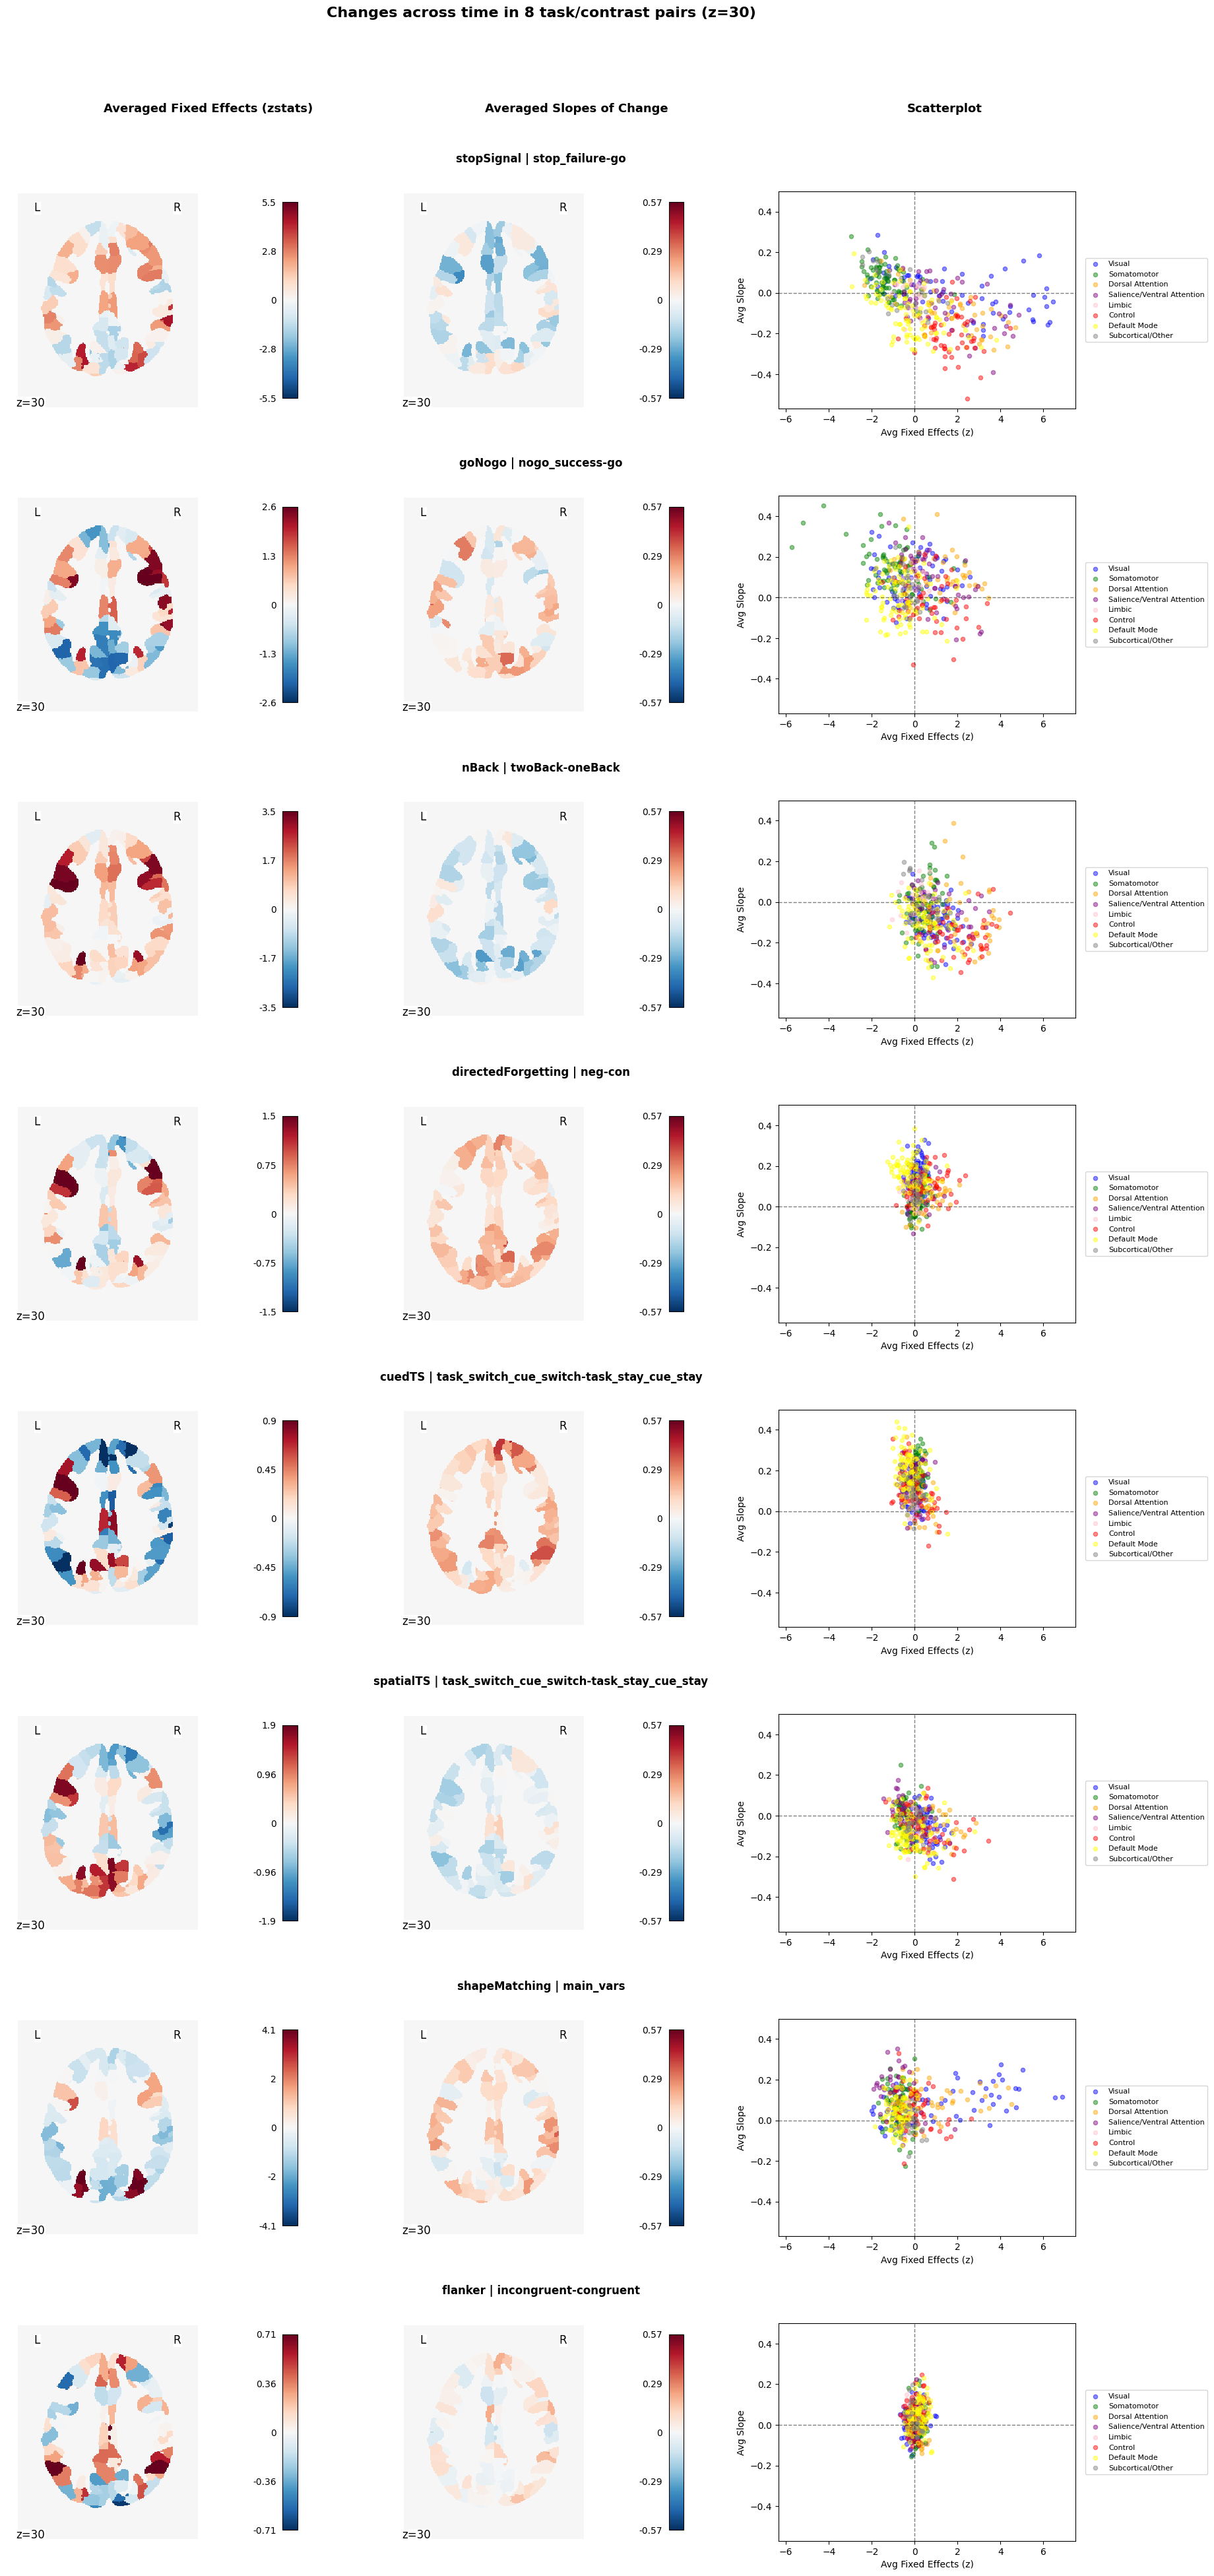

In [67]:
fig = plot_comprehensive_summary(
    avg_activations,
    avg_parcel_traj_results,
    fixed_avg_parcel_traj_results,
    tasks_to_plot,
    z_slice=30,
    x_min=x_min, 
    x_max = x_max, 
    y_min=y_min, 
    y_max = y_max
)

plt.show()

**plot individual subject plots**

In [51]:
def indiv_plot_comprehensive_summary(subj_id, avg_activations, avg_parcel_traj_results, fixed_avg_parcel_traj_results,
                                tasks_to_plot, z_slice=0,
                                x_min=x_min, x_max = x_max, y_min=y_min, y_max = y_max,
                                threshold=None, save_path="OHBM_plot.png"):
    """
    Create a 8x3 plot showing fixed effects, slopes, and scatterplot for each task/contrast.
    
    Parameters:
    -----------
    avg_activations : dict
        Dictionary containing activation data for scatterplots
    avg_parcel_traj_results : dict
        Dictionary containing slope results
    fixed_avg_parcel_traj_results : dict
        Dictionary containing fixed effects results
    tasks_to_plot : dict
        Dictionary mapping task names to contrasts
    z_slice : int
        Brain slice coordinate for axial view
    x_min, x_max, y_min, y_max : float
        Axis limits for scatterplots
    threshold : float
        Threshold for brain maps
    save_path : str, optional
        Path to save the figure
    
    Returns:
    --------
    fig : matplotlib figure
    """
    n_tasks = len(tasks_to_plot)
    fig = plt.figure(figsize=(18, 5*n_tasks))  # 3 columns, n_tasks rows
    
    # Create a grid: n_tasks rows x 3 columns (fixed effects, slopes, scatterplot)
    # Add more top margin to make room for title and headers
    gs = fig.add_gridspec(n_tasks, 3, hspace=0.4, wspace=0.3, top=0.91, bottom=0.02, left=0.05, right=0.95)
    
    task_names = list(tasks_to_plot.keys())
    
    for row_idx, task in enumerate(task_names):
        contrast = tasks_to_plot[task]
        
        print(f"Processing {task} - {contrast}...")
        
        # Get atlas labels (needed for both brain maps)
        atlas_labels = [label.decode('utf-8') if isinstance(label, bytes) else label 
                       for label in atlas_obj.labels]
        
        # Column 0: Fixed effects brain map
        fixed_effects_dict = fixed_avg_parcel_traj_results[task][contrast]
        fixed_effects_data = np.zeros_like(atlas_data)
        
        for i, atlas_label in enumerate(atlas_labels):
            if atlas_label in fixed_effects_dict:
                fixed_effect_value = fixed_effects_dict[atlas_label]['activation']
                
                if hasattr(atlas_obj, 'roi_values'):
                    roi_value = atlas_obj.roi_values[i]
                    fixed_effects_data[atlas_data == roi_value] = fixed_effect_value
                else:
                    fixed_effects_data[atlas_data == (i + 1)] = fixed_effect_value
        
        fixed_effects_img = nib.Nifti1Image(fixed_effects_data, atlas_img.affine)
        nonzero_fe = fixed_effects_data[fixed_effects_data != 0]
        vmin_fe, vmax_fe = np.percentile(nonzero_fe, [2, 98])
        # vmin_fe, vmax_fe = x_min, x_max
        abs_max_fe = max(abs(vmin_fe), abs(vmax_fe))
        
        ax_fe = fig.add_subplot(gs[row_idx, 0])
        plotting.plot_stat_map(fixed_effects_img,
                               colorbar=True,
                               cmap='RdBu_r',
                               vmin=-abs_max_fe,
                               vmax=abs_max_fe,
                               symmetric_cbar=True,
                               threshold=threshold,
                               display_mode='z',
                               axes=ax_fe,
                               cut_coords=[z_slice],
                               draw_cross=False)
        
        # Column 1: Slopes brain map
        parcel_data = avg_parcel_traj_results[task][contrast]
        slope_data = np.zeros_like(atlas_data)
        
        for i, atlas_label in enumerate(atlas_labels):
            if atlas_label in parcel_data:
                slope_value = parcel_data[atlas_label]['slope']
                
                if hasattr(atlas_obj, 'roi_values'):
                    roi_value = atlas_obj.roi_values[i]
                    slope_data[atlas_data == roi_value] = slope_value
                else:
                    slope_data[atlas_data == (i + 1)] = slope_value
        
        slope_img = nib.Nifti1Image(slope_data, atlas_img.affine)
        nonzero_slopes = slope_data[slope_data != 0]
        # vmin_slope, vmax_slope = np.percentile(nonzero_slopes, [2, 98])
        vmin_slope, vmax_slope = y_min, y_max
        abs_max_slope = max(abs(vmin_slope), abs(vmax_slope))
        
        ax_slopes = fig.add_subplot(gs[row_idx, 1])
        plotting.plot_stat_map(slope_img,
                               colorbar=True,
                               cmap='RdBu_r',
                               vmin=-abs_max_slope,
                               vmax=abs_max_slope,
                               symmetric_cbar=True,
                               threshold=threshold,
                               display_mode='z',
                               axes=ax_slopes,
                               cut_coords=[z_slice],
                               draw_cross=False)
        
        # Column 2: Scatterplot
        ax_scatter = fig.add_subplot(gs[row_idx, 2])
        
        # Get parcel names and network categories
        parcels = avg_activations[task][contrast]["parcel_names"]
        network_categories = [get_network_category(p) for p in parcels]
        
        # Get x and y values
        x_all = avg_activations[task][contrast]["fixed_effects_val"]
        y_all = avg_activations[task][contrast]["slope"]
        
        # Plot each network separately for legend
        for network in network_colors.keys():
            mask = [cat == network for cat in network_categories]
            if any(mask):
                x_vals = [x_all[i] for i, m in enumerate(mask) if m]
                y_vals = [y_all[i] for i, m in enumerate(mask) if m]
                
                ax_scatter.scatter(x_vals, y_vals, 
                          c=network_colors[network], 
                          label=network, 
                          alpha=0.45, 
                          s=20)
        
        ax_scatter.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
        ax_scatter.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
        ax_scatter.set_xlabel("Fixed Effects (z)", fontsize=10)
        ax_scatter.set_ylabel("Slope", fontsize=10)
        
        # # Only show legend for first plot
        # if row_idx == 0:
        ax_scatter.legend(fontsize=8, loc='center left', bbox_to_anchor=(1.02, 0.5))
    
        # Set axis limits
        if contrast != "response_time" and x_min is not None:
            ax_scatter.set_xlim(x_min, x_max)
            ax_scatter.set_ylim(y_min, y_max)
        
        # Add task/contrast label - anchored to the middle subplot position
        # Get the position of the middle subplot (slopes)
        bbox = ax_slopes.get_position()
        label_y = bbox.y1 + 0.01  # Slightly above the top of the subplot
        
        fig.text(0.5, label_y, f"{task} | {contrast}", 
                ha='center', va='bottom', fontsize=12, fontweight='bold',
                transform=fig.transFigure)
    
    # Add main title at the very top
    fig.suptitle(f'{subj_id}: Changes across time in 8 task/contrast pairs (z={z_slice})', 
                fontsize=16, fontweight='bold', y=0.98)
    
    # Add column headers - between title and plots
    fig.text(0.22, 0.94, 'Fixed Effects (zstats)', ha='center', fontsize=13, fontweight='bold')
    fig.text(0.53, 0.94, 'Slope of Change', ha='center', fontsize=13, fontweight='bold')
    fig.text(0.84, 0.94, 'Scatterplot', ha='center', fontsize=13, fontweight='bold')
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Figure saved to {save_path}")
    
    return fig

In [52]:
indiv_activations

# Calculate global limits across ALL tasks and contrasts in tasks_to_plot
all_x_vals = []
all_y_vals = []
x_min = 0
x_max = 0
y_min = 0
y_max = 0

for subj in indiv_activations.keys():
    for task in indiv_activations[subj].keys():
        for contrast in indiv_activations[subj][task].keys():
            if (task not in tasks_to_plot):
                continue
            elif (contrast != tasks_to_plot[task]):
                continue
            print(f"looking at {task}|{contrast}")
                
            x_vals = indiv_activations[subj][task][contrast]["fixed_effects_val"]
            y_vals = indiv_activations[subj][task][contrast]["slope"]
            
            # Check if arrays are not empty
            if len(x_vals) > 0 and len(y_vals) > 0:
                all_x_vals.extend(x_vals)
                all_y_vals.extend(y_vals)
            else:
                print(f"Warning: Empty data for {task} - {contrast}")

# Check if we have any data
if len(all_x_vals) == 0 or len(all_y_vals) == 0:
    raise ValueError("No valid data found across tasks and contrasts")

# Calculate limits
x_min, x_max = np.min(all_x_vals), np.max(all_x_vals)
y_min, y_max = np.min(all_y_vals), np.max(all_y_vals)

print(f"before padding: {x_min}-{x_max}")

# Add padding
x_padding = (x_max - x_min) * 0.05
y_padding = (y_max - y_min) * 0.05
x_min -= x_padding
x_max += x_padding
y_min -= y_padding
y_max += y_padding

print(f"X-axis limits (Fixed Effects): [{x_min:.3f}, {x_max:.3f}]")
print(f"Y-axis limits (Slopes): [{y_min:.3f}, {y_max:.3f}]")
print(f"Number of data points: {len(all_x_vals)}")

looking at nBack|twoBack-oneBack
looking at flanker|incongruent-congruent
looking at directedForgetting|neg-con
looking at goNogo|nogo_success-go
looking at shapeMatching|main_vars
looking at stopSignal|stop_failure-go
looking at cuedTS|task_switch_cue_switch-task_stay_cue_stay
looking at spatialTS|task_switch_cue_switch-task_stay_cue_stay
looking at nBack|twoBack-oneBack
looking at flanker|incongruent-congruent
looking at directedForgetting|neg-con
looking at goNogo|nogo_success-go
looking at shapeMatching|main_vars
looking at stopSignal|stop_failure-go
looking at cuedTS|task_switch_cue_switch-task_stay_cue_stay
looking at spatialTS|task_switch_cue_switch-task_stay_cue_stay
looking at nBack|twoBack-oneBack
looking at flanker|incongruent-congruent
looking at directedForgetting|neg-con
looking at goNogo|nogo_success-go
looking at shapeMatching|main_vars
looking at stopSignal|stop_failure-go
looking at cuedTS|task_switch_cue_switch-task_stay_cue_stay
looking at spatialTS|task_switch_cue_

Processing stopSignal - stop_failure-go...
Processing goNogo - nogo_success-go...
Processing nBack - twoBack-oneBack...
Processing directedForgetting - neg-con...
Processing cuedTS - task_switch_cue_switch-task_stay_cue_stay...
Processing spatialTS - task_switch_cue_switch-task_stay_cue_stay...
Processing shapeMatching - main_vars...
Processing flanker - incongruent-congruent...
Figure saved to sub-s03_OHBM_plot.png
Processing stopSignal - stop_failure-go...
Processing goNogo - nogo_success-go...
Processing nBack - twoBack-oneBack...
Processing directedForgetting - neg-con...
Processing cuedTS - task_switch_cue_switch-task_stay_cue_stay...
Processing spatialTS - task_switch_cue_switch-task_stay_cue_stay...
Processing shapeMatching - main_vars...
Processing flanker - incongruent-congruent...
Figure saved to sub-s10_OHBM_plot.png
Processing stopSignal - stop_failure-go...
Processing goNogo - nogo_success-go...
Processing nBack - twoBack-oneBack...
Processing directedForgetting - neg-con.

KeyError: 'stopSignal'

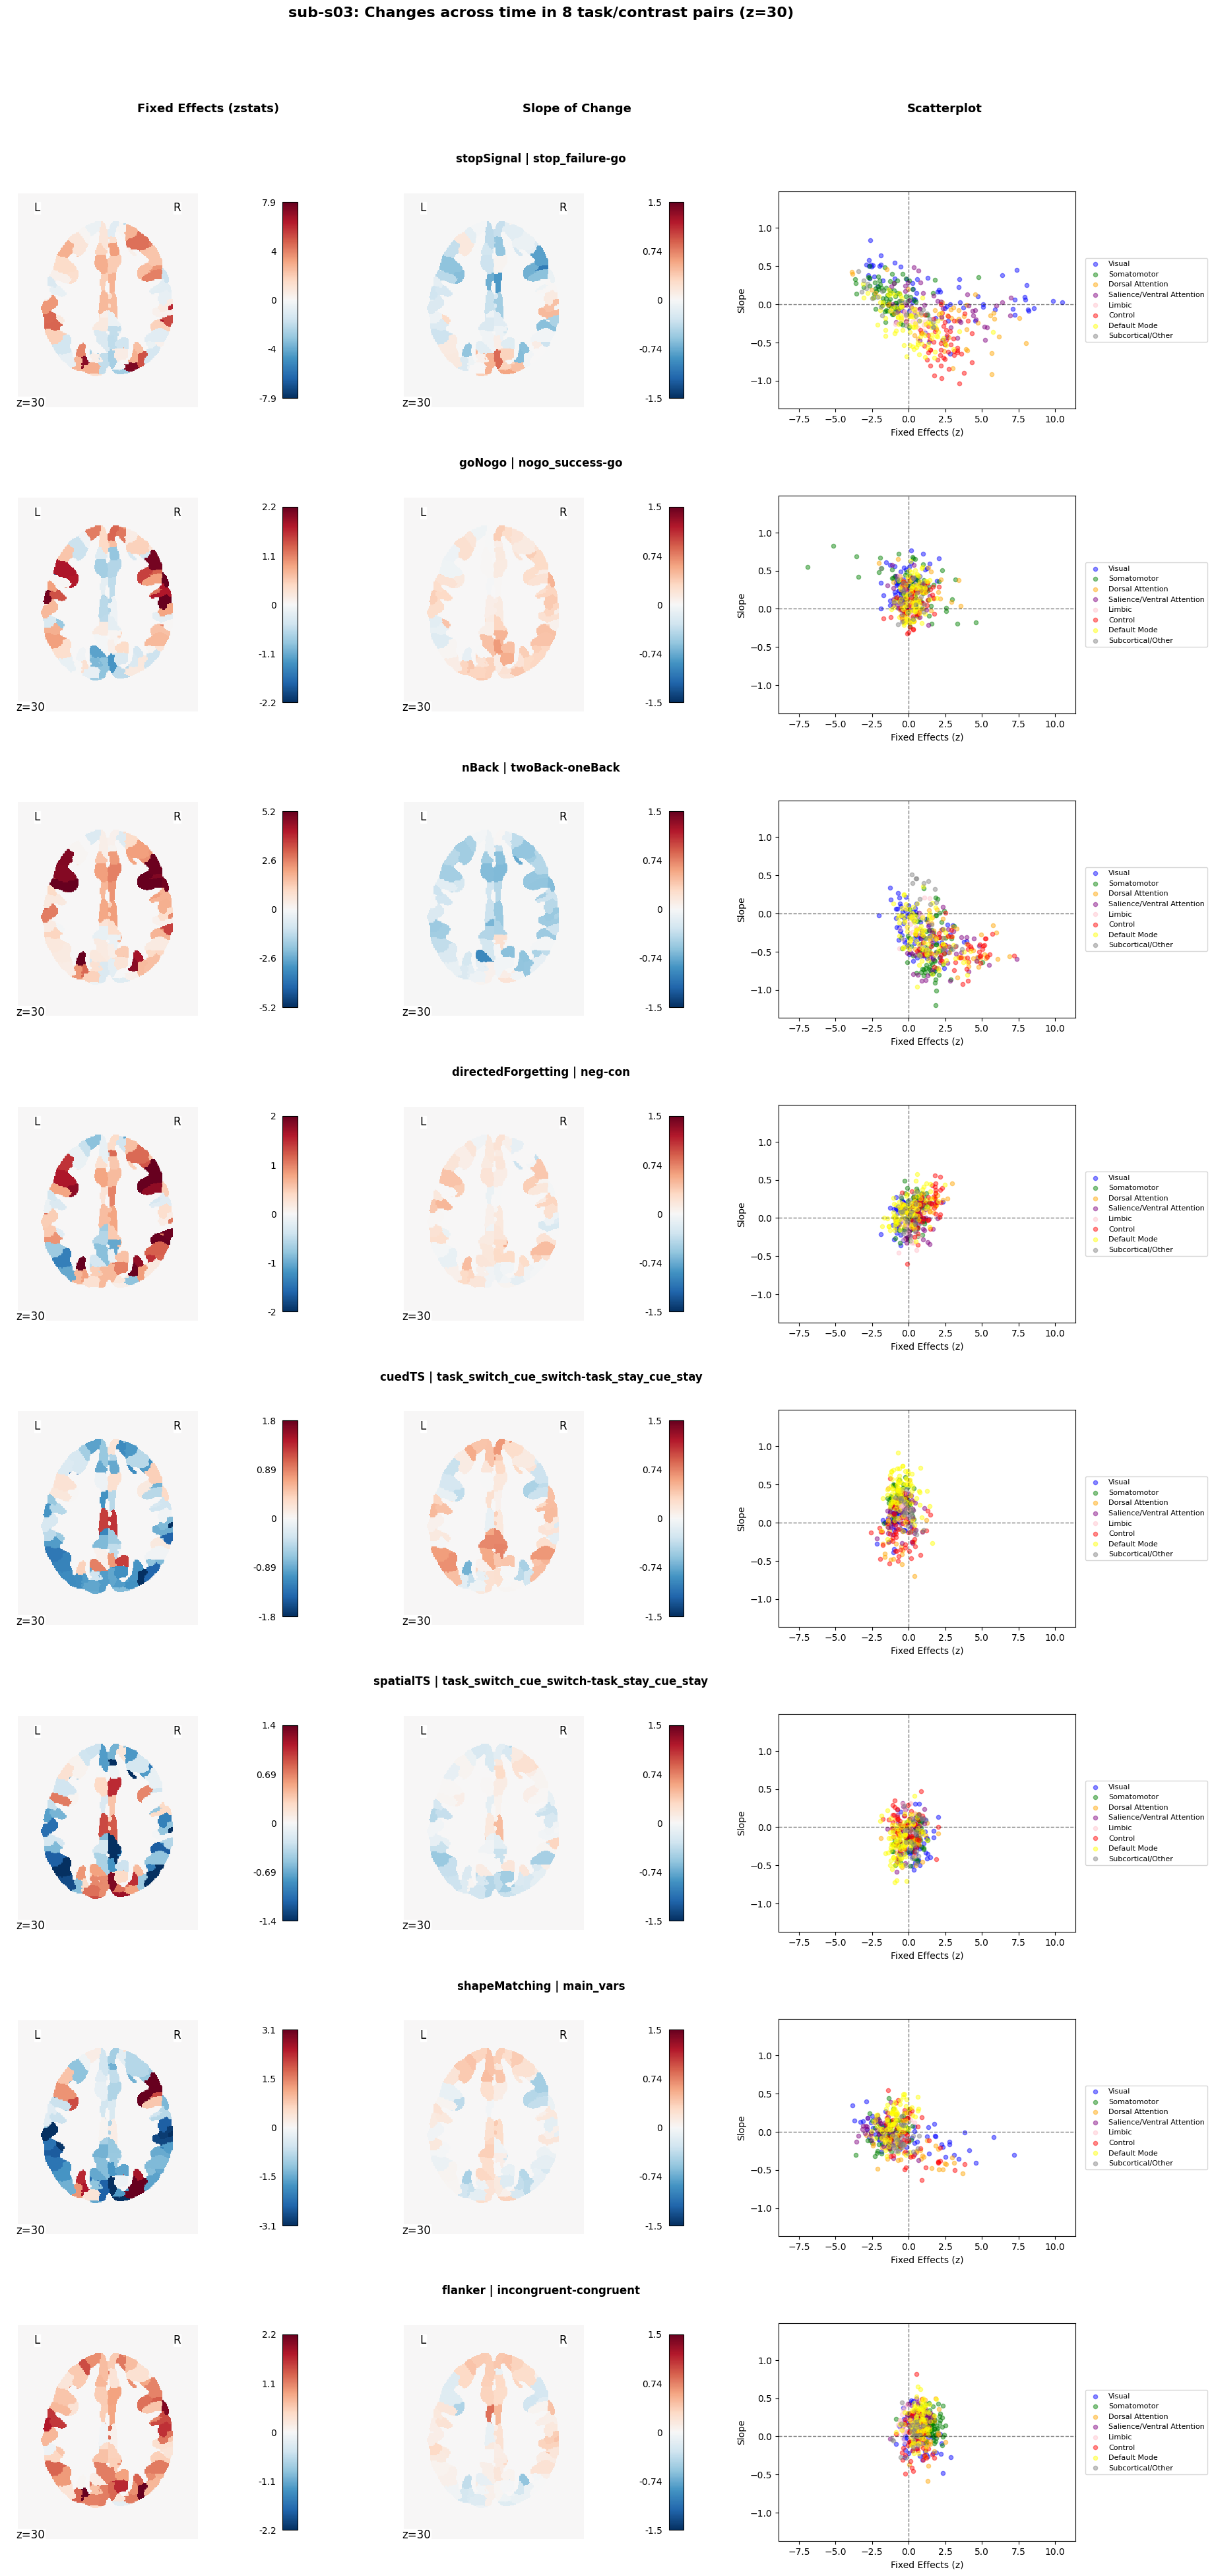

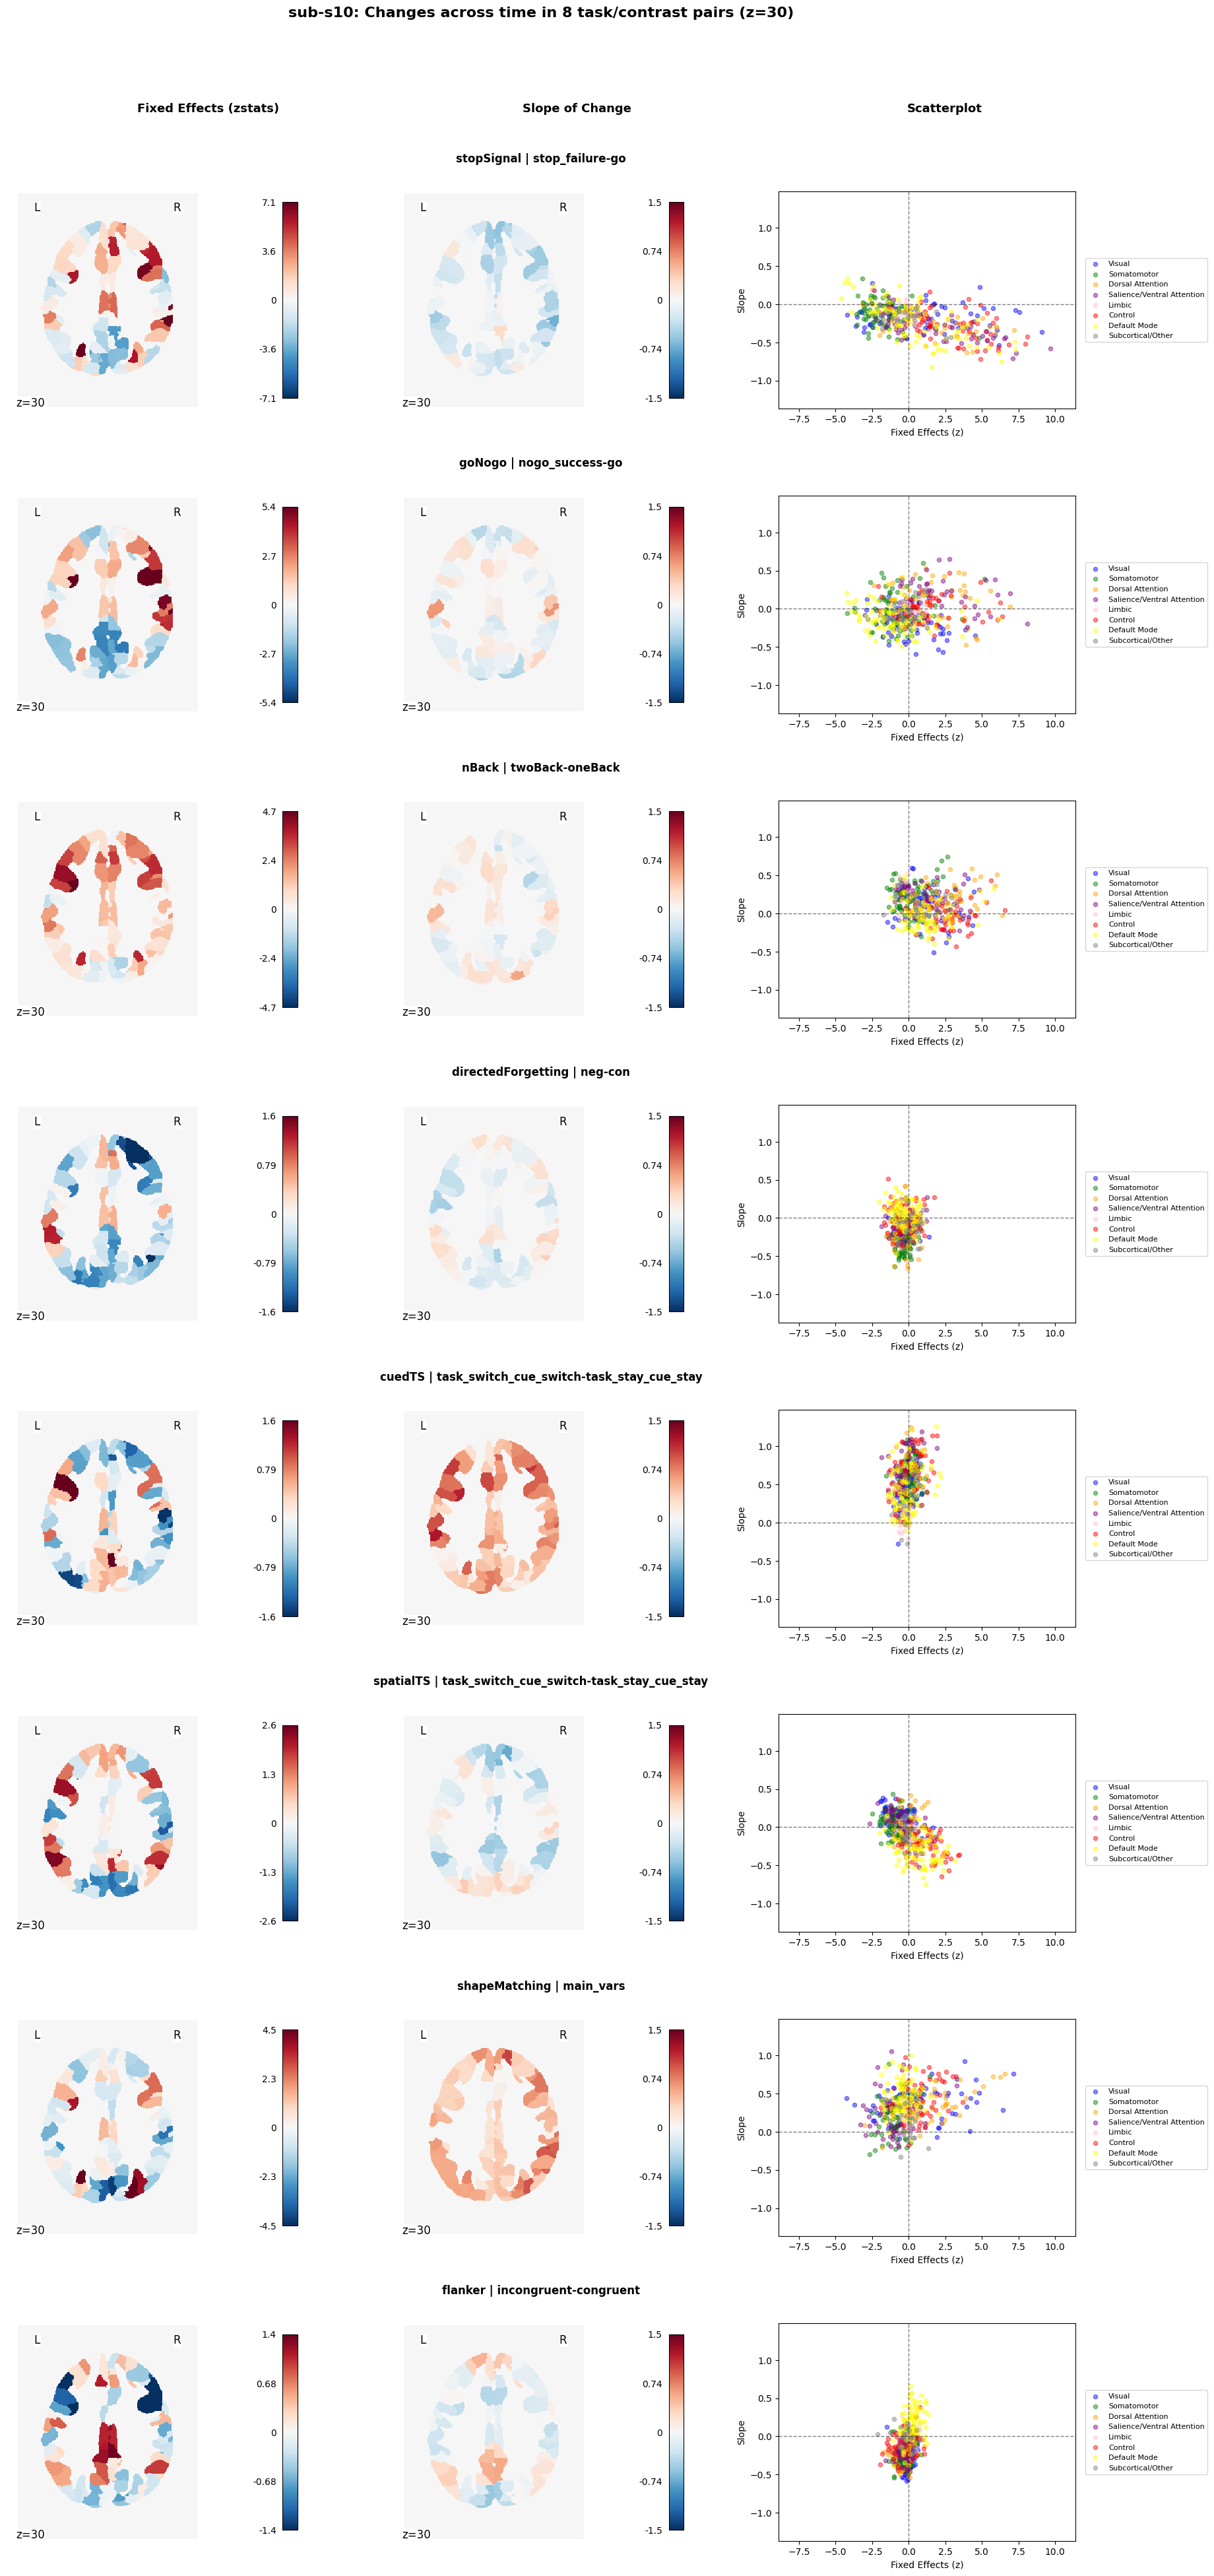

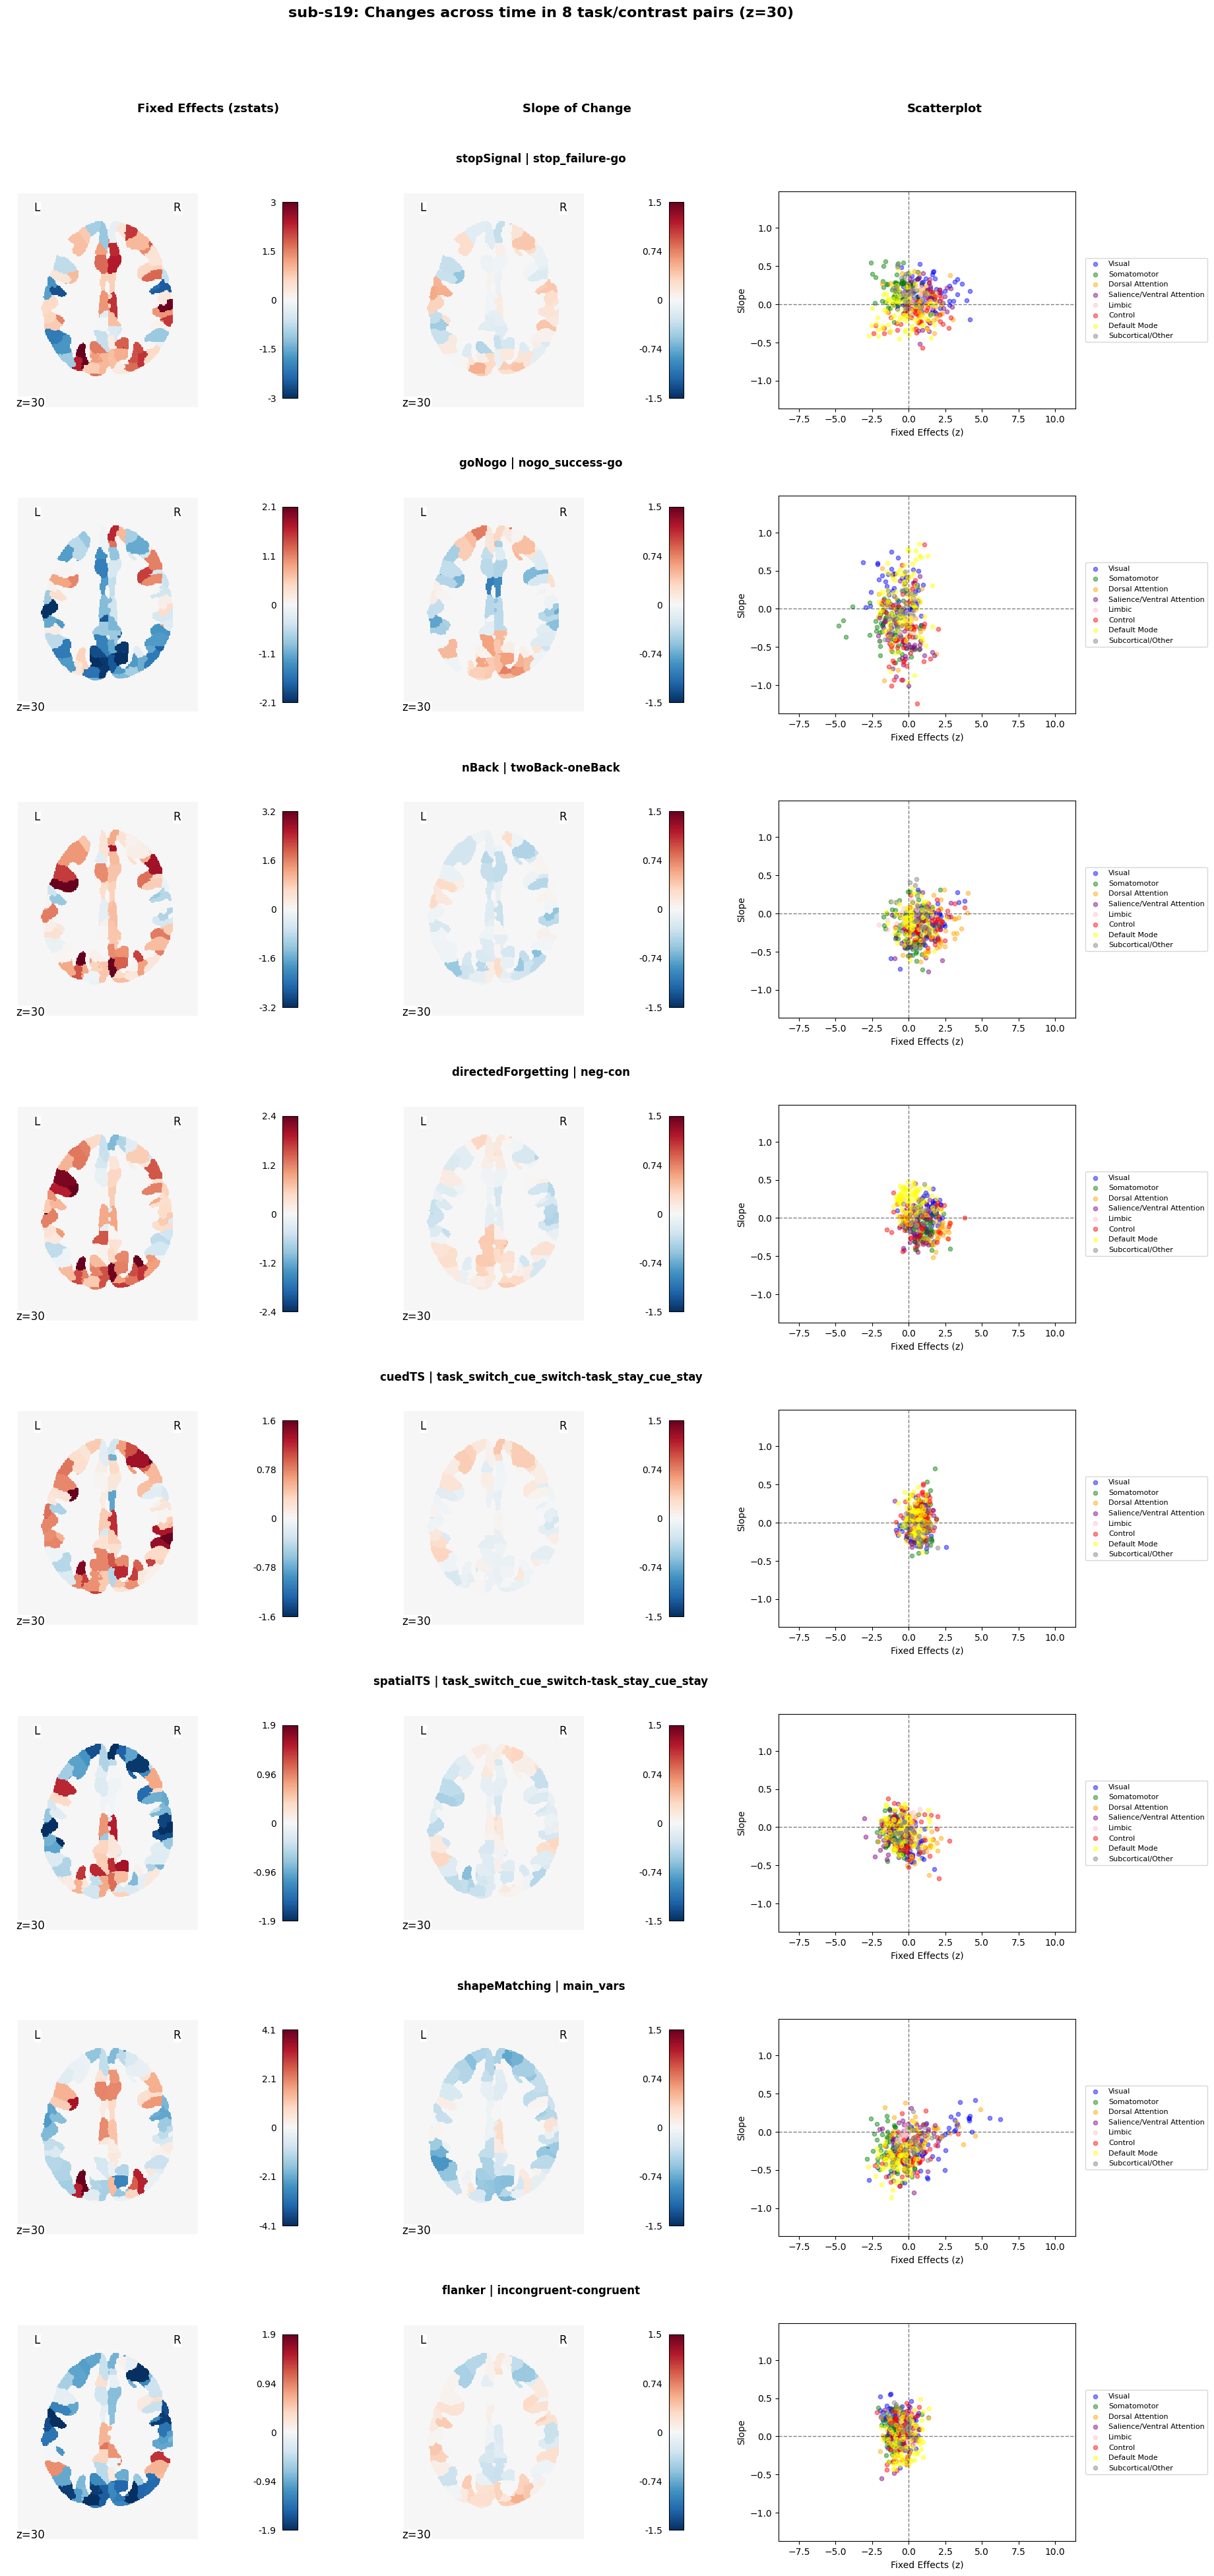

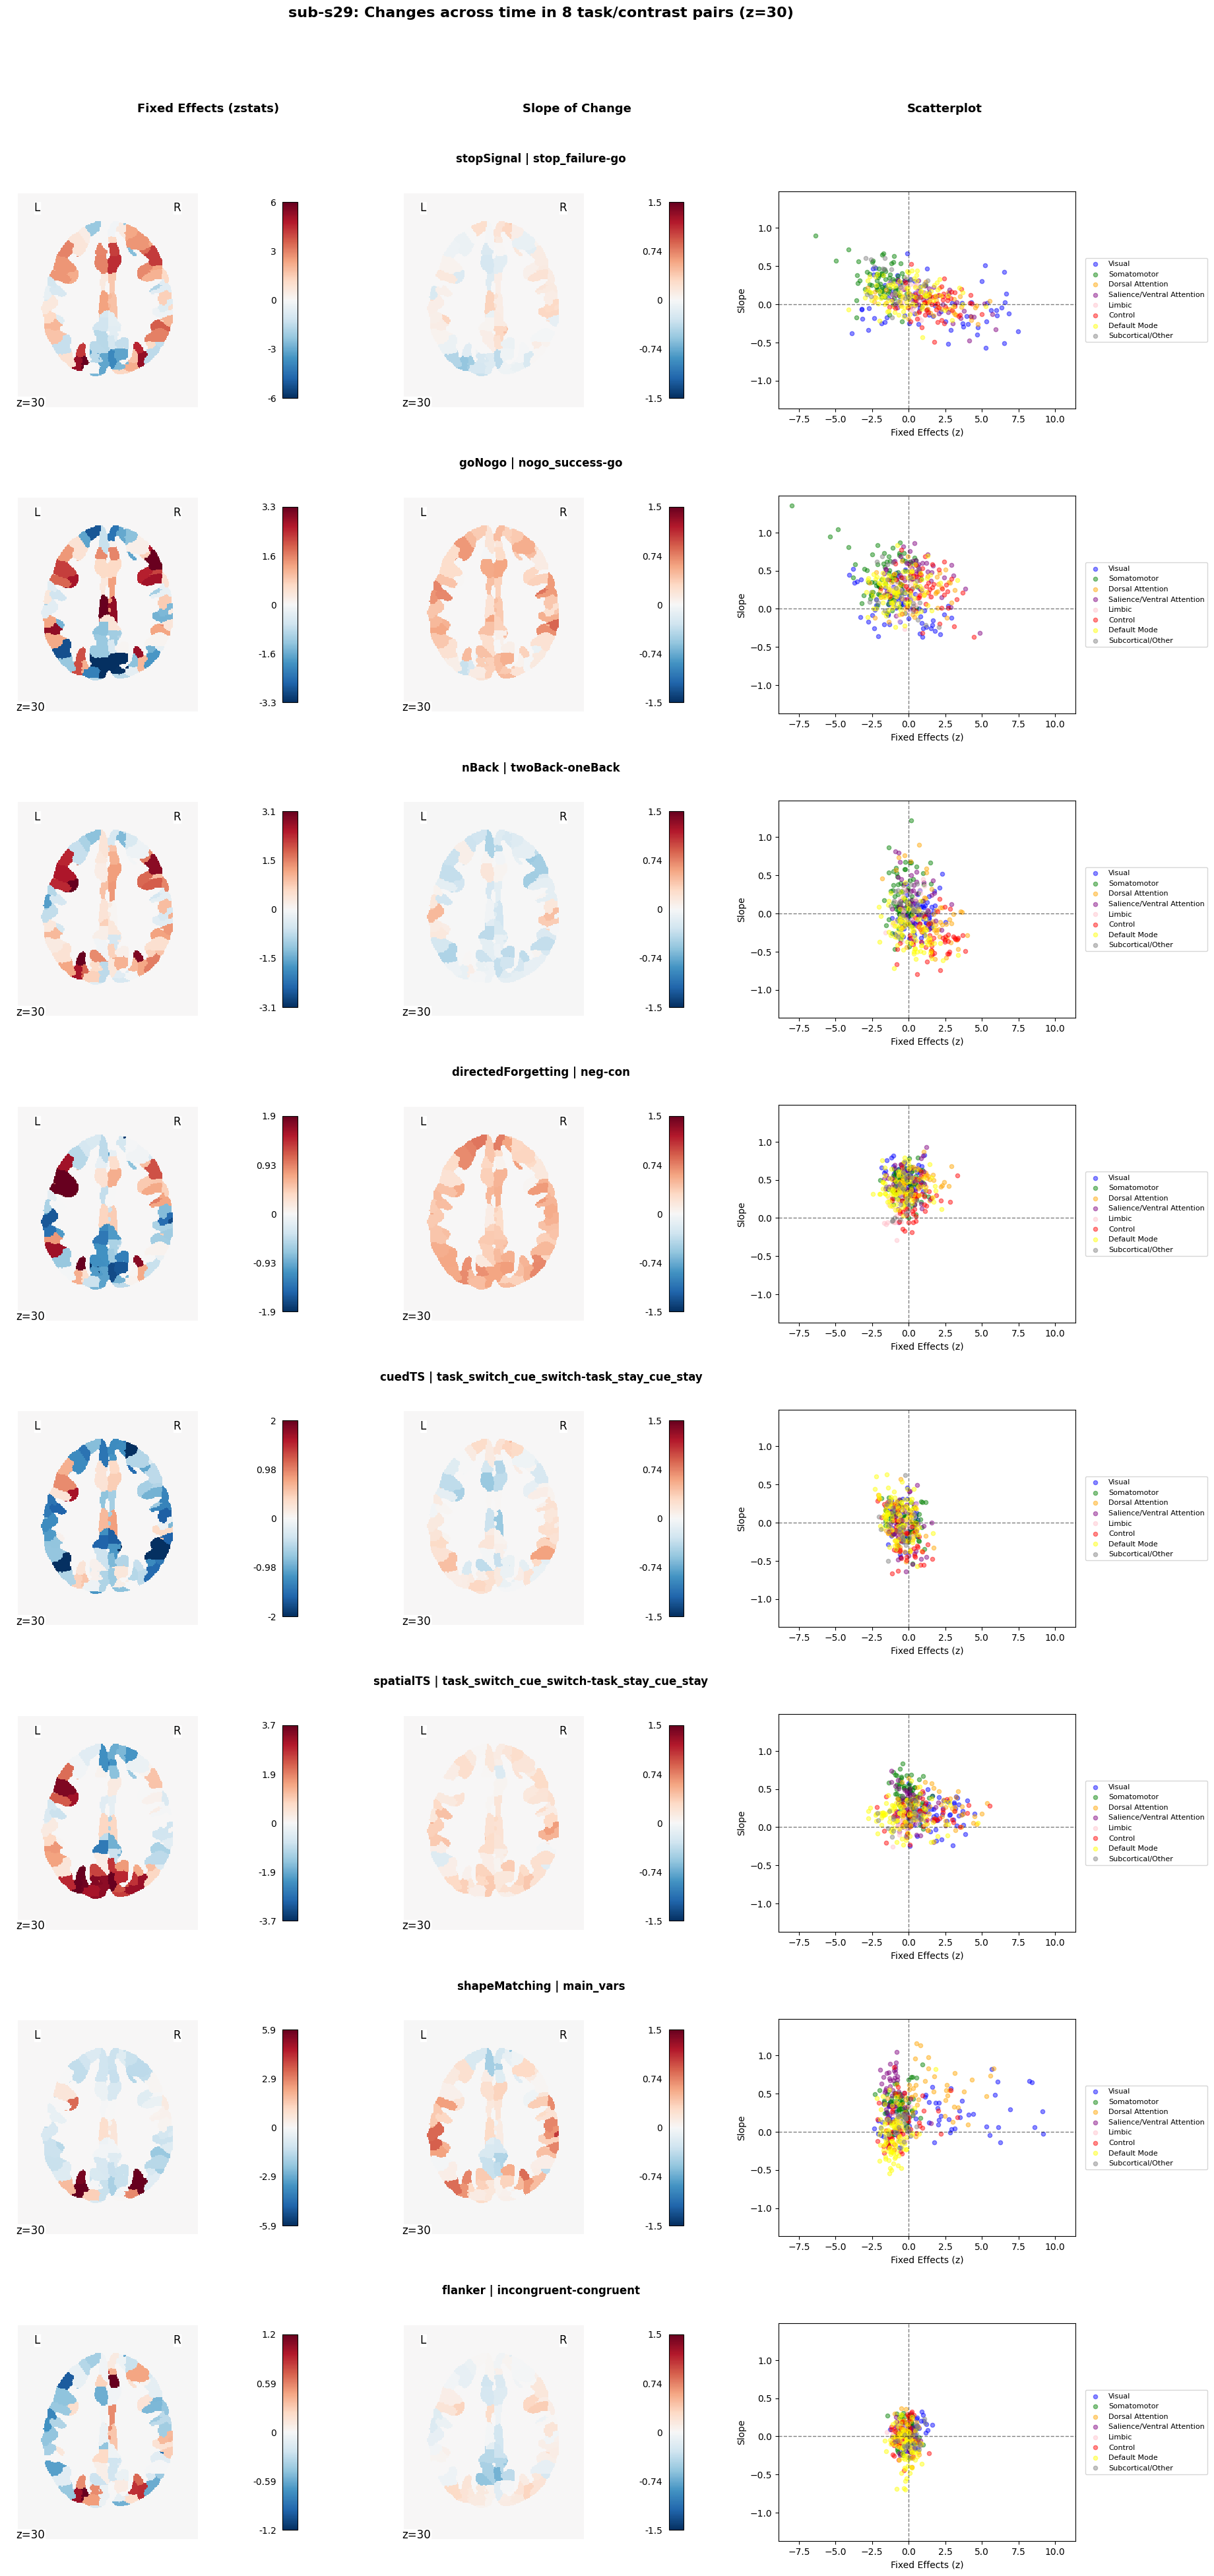

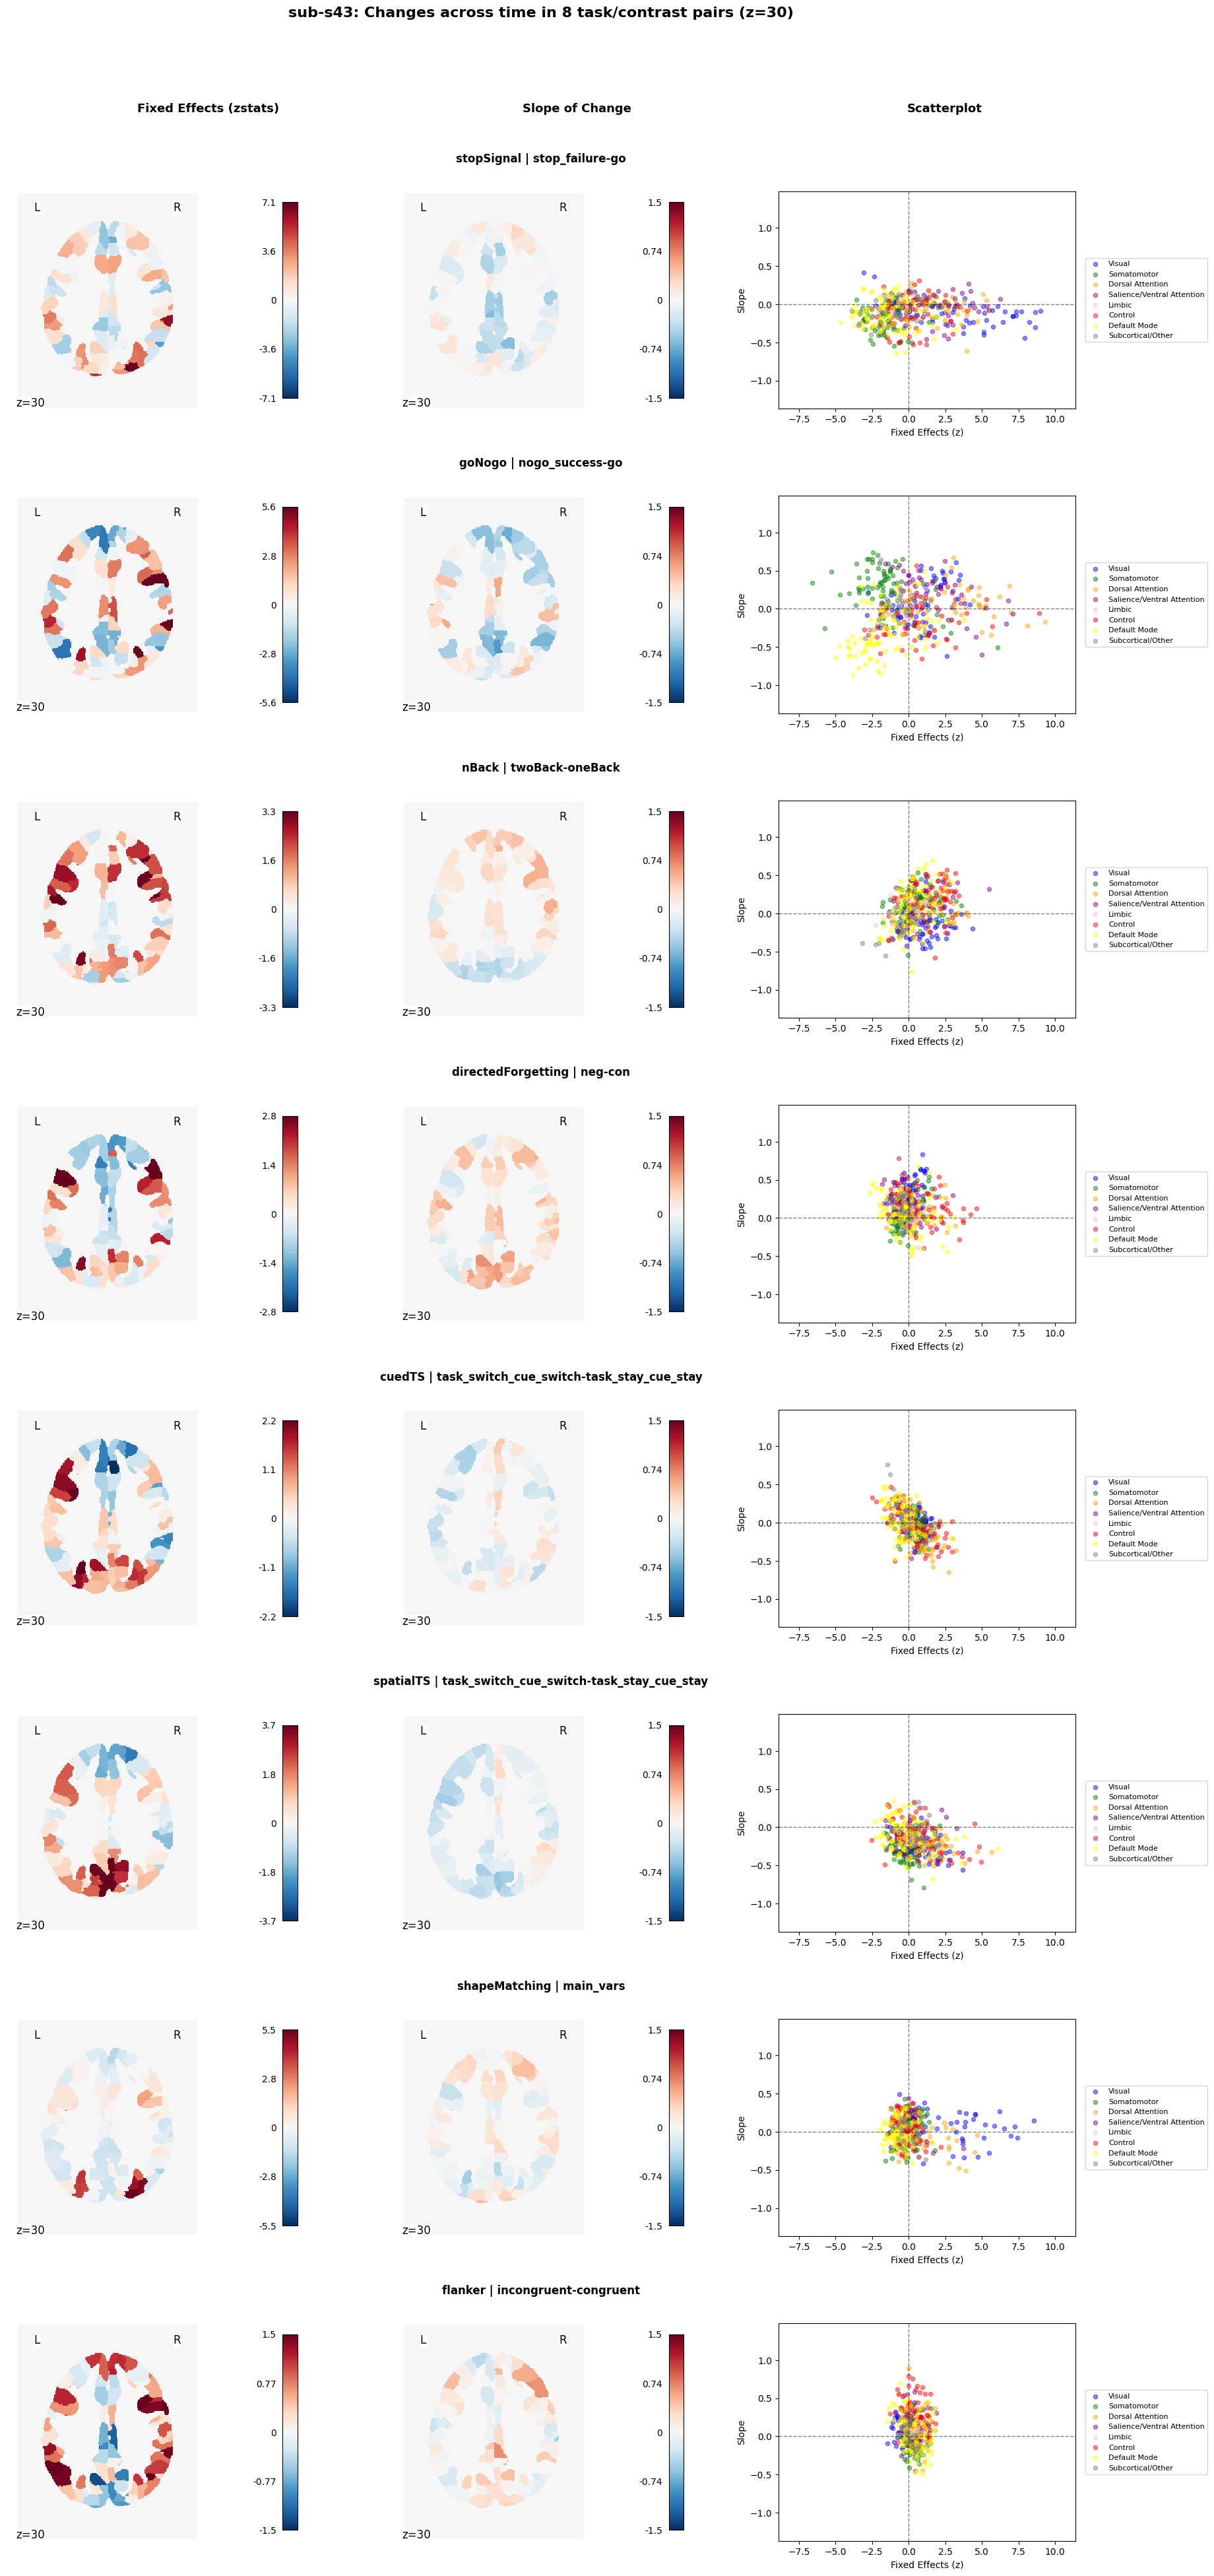

In [57]:
subject_ids = list(indiv_activations.keys())

for subj_id in subject_ids:
    save_name = f"{subj_id}_OHBM_plot.png"
    subj_activations = indiv_activations[subj_id]
    indiv_plot_comprehensive_summary(subj_id, subj_activations, indiv_parcel_traj_results[subj_id], indiv_fixed_parcel_dict[subj_id],
                                    tasks_to_plot, z_slice=30,
                                    x_min=x_min, x_max = x_max, y_min=y_min, y_max = y_max,
                                    threshold=None, save_path=save_name)